# Plot the very long term trajectories of stars on the sky

Calculate the celestial positions for sources for future epochs and plot the resulting trajectory of the stars on the sky. The aim is to reproduce the GaiaSky produced version that Stefan Jordan proposed as Gaia EDR3 release image. The resulting image corresponds to the end-frame for the animation produced with the `star-trails-animation.py` code

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
import astropy.units as u

import cartopy.crs as ccrs

from astroquery.simbad import Simbad
from pygaia.astrometry.coordinates import EpochPropagation, CoordinateTransformation, Transformations

## Load the background image

This image will be displayed to provide context to the star trails. The Gaia all-sky colour image is chosen here. It is used in its Cartesian projection form so that it can be projected onto any other spherical projection.

In [4]:
backgr = plt.imread('./sky-images/GaiaSky-colour-2k.png')

## Sample of stars

Any sample of stars with proper motions can be used in principle. Here a set of stars from Gaia EDR3 is used, selected as follows:

```
select ra, dec, parallax, pmra, pmdec, dr2_radial_velocity, phot_g_mean_mag
from gaiaedr3.gaia_source
where astrometric_params_solved != 3
and parallax_over_error>10 and parallax>10
and ruwe<1.4
and dr2_radial_velocity is not null
and dr2_rv_nb_transits > 3
and bp_rp is not null
```

This selection corresponds to stars with precise parallaxes, nominally closer than 100 pc, and with reliable astrometry and reliable DR2 radial velocities. The radial velocties are needed to correctly propagate the star positions into the future.

To keep the runtime below fast, only a random subset of the stars is used.

In [5]:
data = Table.read('./data/StarTrailVideoSample.fits')

nsample = 2000
np.random.default_rng(53949896)
raninds = np.random.choice(np.arange(data['ra'].size), nsample)

ra0 = np.deg2rad(data['ra'][raninds])
dec0 = np.deg2rad(data['dec'][raninds])
plx0 = data['parallax'][raninds]
pmra0 = data['pmra'][raninds]
pmdec0 = data['pmdec'][raninds]
vrad0 = data['dr2_radial_velocity'][raninds]
mag = data['phot_g_mean_mag'][raninds]

## Predict the future positions

Next the celestial positions of the stars are predicted over a certain time interval (`delta_epoch`) into the future, starting from the Gaia EDR3 reference epoch J2016.0. The predicted position are transformed to Galactic coordinates.

In [6]:
ct = CoordinateTransformation(Transformations.ICRS2GAL)

n_epochs = 200
t0 = 2016.0 
delta_epoch = 8.0e+5 # years
epochs = np.linspace(t0, t0+delta_epoch, n_epochs)
epp = EpochPropagation()

l1 = np.zeros((nsample, n_epochs))
b1 = np.zeros((nsample, n_epochs))

for i, t1 in zip(range(n_epochs), epochs):
    ra1, dec1 = epp.propagate_pos(ra0, dec0, plx0, pmra0, pmdec0, vrad0, t0, t1)
    l1[:,i], b1[:,i] = ct.transform_sky_coordinates(ra1, dec1)

l1 = np.rad2deg(l1)
b1 = np.rad2deg(b1)

## Plot the trails

Next the trails calculated above are plotted on the sky. Here a Mollweide projection is chosen.

The loop that iterates over each of the stars contains code to deal with the cases where stars move in longitude from $-\pi$ to $+\pi$ or vice versa. This is to prevent a line being drawn across the whole image connecting the points on either side of the disontinuity in longitude.

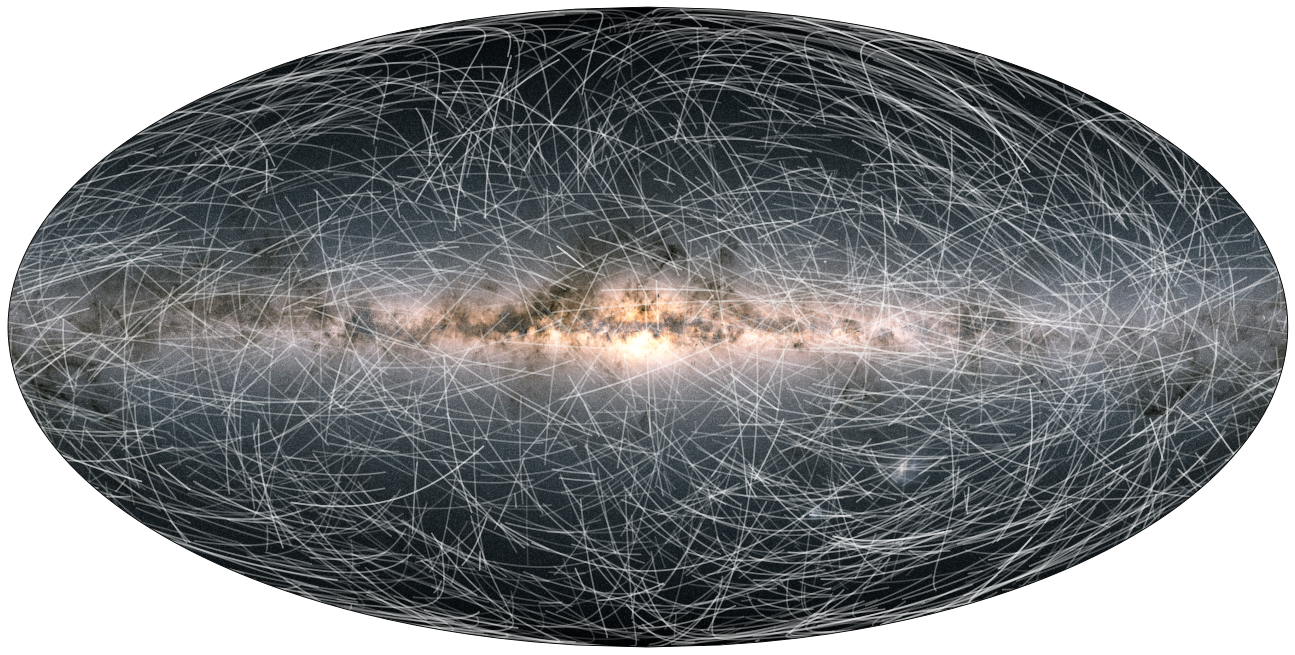

In [7]:
magrange = mag.max()-mag.min()
magscaled_trails = 0.1+0.5*(mag.max()-mag)/magrange

fig=plt.figure(figsize=(16,9), dpi=80, frameon=False, tight_layout={'pad':0.01})

ax1 = fig.add_subplot(projection=ccrs.Mollweide())
default_projection = ccrs.PlateCarree()
ax1.imshow(np.fliplr(backgr), transform=default_projection, zorder=-1, origin='upper')
for i in range(nsample):
    l = l1[i,:]
    b = b1[i,:]
    l[l>180] = l[l>180]-360.0
    diffs = l[1:]-l[0:-1]
    if np.all(diffs>0) or np.all(diffs<0):
        ax1.plot(l, b, c='w', alpha=magscaled_trails[i], transform=default_projection)
    else:
        indices=(l>=0.0)
        if np.any(indices):
            xplot=l[indices]
            yplot=b[indices]
            ax1.plot(xplot, yplot, c='w', alpha=magscaled_trails[i], transform=default_projection)
        indices=(l<0.0)
        if np.any(indices):
            xplot=l[indices]
            yplot=b[indices]
            ax1.plot(xplot, yplot, c='w', alpha=magscaled_trails[i], transform=default_projection)

ax1.set_global()
ax1.invert_xaxis()

plt.show()